# n = 2 mln

In [2]:
# Prepare

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
import matplotlib
import pickle
import scipy

def sns_styleset():
    sns.set_context('paper')
    sns.set_style('ticks')
    matplotlib.rcParams['axes.linewidth']    = .75
    matplotlib.rcParams['xtick.major.width'] = .75
    matplotlib.rcParams['ytick.major.width'] = .75
    matplotlib.rcParams['xtick.major.size'] = 3
    matplotlib.rcParams['ytick.major.size'] = 3
    matplotlib.rcParams['xtick.minor.size'] = 2
    matplotlib.rcParams['ytick.minor.size'] = 2
    matplotlib.rcParams['font.size']       = 7
    matplotlib.rcParams['axes.titlesize']  = 7
    matplotlib.rcParams['axes.labelsize']  = 7
    matplotlib.rcParams['legend.fontsize'] = 7
    matplotlib.rcParams['xtick.labelsize'] = 7
    matplotlib.rcParams['ytick.labelsize'] = 7

sns_styleset()

In [8]:
clusterColors = np.array('''#c886ba #5cbb5e #9751a0 #84b941 #8e6db0 #bbbb3c #5667b0 #e58824 #778cc6 #d6ac3d
#785aa5 #204a87 #36384a #5ec08d #e53e77 #50c1b4 #dd464a #3bbbc6 #d6552c #5baada #cf8a34 #4d62ad
#8b8a34 #a34f9a #9db36b #cb4188 #37825c #b23d4f #5d7131 #b59ac9 #a55725 #5277af #e38f68 #86619d
#caa56a #9c476d #886a2c #dd81a9'''.split())

np.random.seed(42)
ind25k  = np.random.choice(clusters.size, 25000, replace=False)
[Z25k, pos] = pickle.load(open('big-pickles/cao-downsampling.pickle', 'rb'))
X = pickle.load(open('big-pickles/cao-pca.pickle', 'rb'))
Zs, clusters, clusterNames = pickle.load(open('big-pickles/cao-tsne.pickle', 'rb'))

print(list(Zs.keys()))

['pcainit', 'noexagg-pcainit', 'noexagg', 'randinit', 'default', 'paper', 'scanpy', 'mine', 'umap', 'belkina']


In [7]:
print(np.shape(Zs['paper']))
print(np.sum(clusters<0))
print(np.sum(clusters>=0))

(2058652, 2)
32011
2026641


In [10]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist

def embedding_quality(X, Z, classes, knn_classes=10, subsetsize=1000, seed=42):
    cl, cl_inv = np.unique(classes, return_inverse=True)
    C = cl.size
    mu1 = np.zeros((C, X.shape[1]))
    mu2 = np.zeros((C, Z.shape[1]))
    for c in range(C):
        mu1[c,:] = np.mean(X[cl_inv==c,:], axis=0)
        mu2[c,:] = np.mean(Z[cl_inv==c,:], axis=0)
        
    nbrs1 = NearestNeighbors(n_neighbors=knn_classes).fit(mu1)
    ind1 = nbrs1.kneighbors(return_distance=False)
    nbrs2 = NearestNeighbors(n_neighbors=knn_classes).fit(mu2)
    ind2 = nbrs2.kneighbors(return_distance=False)
    
    intersections = 0.0
    for i in range(C):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn_global = intersections / C / knn_classes
    
    np.random.seed(seed)
    subset = np.random.choice(X.shape[0], size=subsetsize, replace=False)
    d1 = pdist(X[subset,:])
    d2 = pdist(Z[subset,:])
    rho = scipy.stats.spearmanr(d1[:,None],d2[:,None]).correlation
    
    return (mnn_global, rho)

ind4metric = clusters>=0
metrics = {}
for key in Zs.keys():
    metrics[key] = embedding_quality(X[ind4metric,:], Zs[key][ind4metric,:], clusters[ind4metric])

## 2K genes

<IPython.core.display.Javascript object>


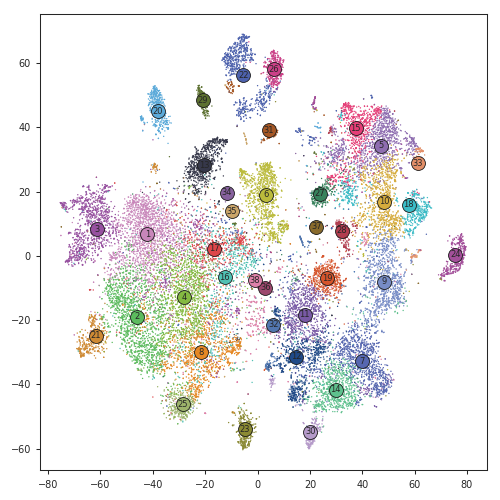

In [11]:
plt.figure(figsize=(5,5))
plt.scatter(Z25k[:,0], Z25k[:,1], s=1, c=clusterColors[clusters][ind25k], 
            edgecolor='none')
plt.tight_layout()

for cl in range(38):
    mu = np.median(Z25k[clusters[ind25k]==cl,:], axis=0)
    plt.scatter(mu[0], mu[1], c=clusterColors[cl], s=100, edgecolor='k', linewidth=.6)
    plt.text(mu[0], mu[1], cl+1, fontsize=6, ha='center', va='center')

<IPython.core.display.Javascript object>


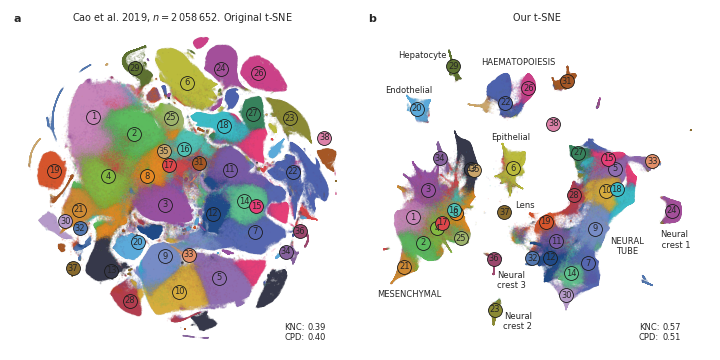

In [13]:
plt.figure(figsize=(7.2, 3.6))
np.random.seed(42)
ind = np.random.permutation(np.sum(clusters>=0))

plt.subplot(121)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.scatter(Zs['paper'][clusters>=0,0][ind], Zs['paper'][clusters>=0,1][ind], s=1,
            c=clusterColors[clusters][clusters>=0][ind], 
            edgecolor='none', alpha=.1, rasterized=True)
for cl in range(38):
    mu = np.median(Zs['paper'][clusters==cl,:], axis=0)
    plt.scatter(mu[0], mu[1], c=clusterColors[cl], s=100, edgecolor='k', linewidth=.6)
    plt.text(mu[0], mu[1], cl+1, fontsize=6, ha='center', va='center')
plt.xticks([])
plt.yticks([])
plt.title('Cao et al. 2019, ' r'$n=2\,058\,652$' '. Original t-SNE')
plt.text(0.8,.02,'KNC:\nCPD:', transform=plt.gca().transAxes, fontsize=6)
plt.text(0.87,.02,'{:.2f}\n{:.2f}'.format(*metrics['paper']), transform=plt.gca().transAxes, fontsize=6)

plt.subplot(122)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.scatter(Zs['mine'][clusters>=0,0][ind], Zs['mine'][clusters>=0,1][ind], s=1,
            c=clusterColors[clusters][clusters>=0][ind], 
            edgecolor='none', alpha=.1, rasterized=True)
for cl in range(38):
    mu = np.median(Zs['mine'][clusters==cl,:], axis=0)
    plt.scatter(mu[0], mu[1], c=clusterColors[cl], s=100, edgecolor='k', linewidth=.6)
    plt.text(mu[0], mu[1], cl+1, fontsize=6, ha='center', va='center')
plt.xticks([])
plt.yticks([])
plt.title('Our t-SNE')
plt.text(0.8,.02,'KNC:\nCPD:', transform=plt.gca().transAxes, fontsize=6)
plt.text(0.87,.02,'{:.2f}\n{:.2f}'.format(*metrics['mine']), transform=plt.gca().transAxes, fontsize=6)

trajectories = {'Endothelial': [-15,17], 'MESENCHYMAL': [-15,-13],
                'NEURAL\nTUBE': [17, -6], 'Neural\n crest 1': [24, -5],
                'HAEMATOPOIESIS': [1, 21], 'Epithelial': [0,10],
                'Hepatocyte': [-13, 22], 'Neural\ncrest 2': [1, -17],
                'Neural\ncrest 3': [0, -11], 'Lens': [2,0]}
for t in trajectories:
    plt.text(trajectories[t][0], trajectories[t][1], t,
             fontsize=6, ha='center', va='center')

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.text(0, 1.02, 'a', transform = plt.gcf().get_axes()[0].transAxes, fontsize=8, fontweight='bold')
plt.text(0, 1.02, 'b', transform = plt.gcf().get_axes()[1].transAxes, fontsize=8, fontweight='bold')

plt.savefig('revision/2mln.png', dpi=200)
plt.savefig('revision/2mln.pdf', dpi=300)
plt.savefig('revision/2mln-600.pdf', dpi=600)

<IPython.core.display.Javascript object>


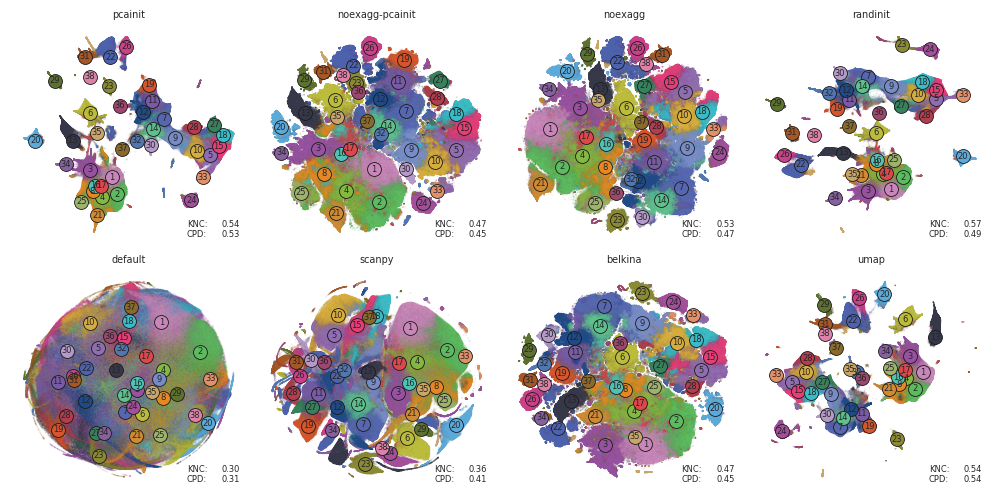

In [14]:
# Other variants

plt.figure(figsize=(10,5))
np.random.seed(42)
ind = np.random.permutation(np.sum(clusters>=0))

for i,key in enumerate(['pcainit', 'noexagg-pcainit', 'noexagg', 'randinit', 
                        'default', 'scanpy', 'belkina', 'umap']):
    plt.subplot(2,4,i+1)
    plt.scatter(Zs[key][clusters>=0,0][ind], Zs[key][clusters>=0,1][ind], s=1,
            c=clusterColors[clusters][clusters>=0][ind], 
            edgecolor='none', alpha=.1, rasterized=True)

    for cl in range(38):
        mu = np.median(Zs[key][clusters==cl,:], axis=0)
        plt.scatter(mu[0], mu[1], c=clusterColors[cl], s=100, edgecolor='k', linewidth=.6)
        plt.text(mu[0], mu[1], cl+1, fontsize=6, ha='center', va='center')
        
    plt.xticks([])
    plt.yticks([])
    plt.title(key)
    plt.text(0.75,.02,'KNC:\nCPD:', transform=plt.gca().transAxes, fontsize=6)
    plt.text(0.9,.02,'{:.2f}\n{:.2f}'.format(*metrics[key]), transform=plt.gca().transAxes, fontsize=6)

sns.despine(left=True, bottom=True)
plt.tight_layout()